In [1]:
# %%
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import awkward as ak # Using awkward array for easier handling of jagged data
import time # For timing steps

# ------------------------------------------------------------
# 1. Data Loading and Initial Setup (Mostly Unchanged)
# ------------------------------------------------------------

def load_root_file(file_path, branches=None, print_branches=False):
    """Loads specified branches from a ROOT file into a dictionary of Awkward Arrays."""
    all_branches = {}
    try:
        with uproot.open(file_path) as file:
            tree = file["tree"]
            if branches is None: branches = tree.keys()
            if print_branches: print("Branches found:", tree.keys())
            loaded_branches_count = 0
            missing_branches = []
            for branch in branches:
                if branch not in tree:
                    print(f"Warning: Branch '{branch}' not found in tree. Skipping.")
                    missing_branches.append(branch)
                    continue
                try:
                    all_branches[branch] = tree[branch].array(library="ak")
                    loaded_branches_count += 1
                except Exception as e:
                    print(f"Warning: Could not load branch '{branch}'. Error: {e}")
                    missing_branches.append(branch)
            num_entries = tree.num_entries
            print(f"Successfully loaded {loaded_branches_count}/{len(branches)} requested branches for {num_entries} events.")
            if missing_branches: print(f"Missing branches: {missing_branches}")
    except FileNotFoundError:
        print(f"Error: ROOT file not found at {file_path}"); return None, 0
    except Exception as e:
        print(f"Error opening or reading ROOT file {file_path}: {e}"); return None, 0
    return all_branches, num_entries

branches_list = [
    't3_betaIn', 't3_radius', 't3_pMatched', 't3_matched_simIdx',
    't3_hit_0_r', 't3_hit_0_z', 't3_hit_0_eta', 't3_hit_0_phi',
    't3_hit_2_r', 't3_hit_2_z', 't3_hit_2_eta', 't3_hit_2_phi',
    't3_hit_4_r', 't3_hit_4_z', 't3_hit_4_eta', 't3_hit_4_phi',
    't3_rzChiSquared'
]
file_path = "t3_embed.root"
branches_data, n_events = load_root_file(file_path, branches_list, print_branches=True)

Branches found: ['sim_pt', 'sim_eta', 'sim_phi', 'sim_pca_dxy', 'sim_pca_dz', 'sim_q', 'sim_event', 'sim_pdgId', 'sim_vx', 'sim_vy', 'sim_vz', 'sim_trkNtupIdx', 'sim_TC_matched', 'sim_TC_matched_mask', 'tc_pt', 'tc_eta', 'tc_phi', 'tc_type', 'tc_isFake', 'tc_isDuplicate', 'tc_matched_simIdx', 'sim_dummy', 'tc_dummy', 'pT5_matched_simIdx', 'pT5_hitIdxs', 'sim_pT5_matched', 'pT5_pt', 'pT5_eta', 'pT5_phi', 'pT5_isFake', 't5_sim_vxy', 't5_sim_vz', 'pT5_isDuplicate', 'pT5_score', 'pT5_layer_binary', 'pT5_moduleType_binary', 'pT5_matched_pt', 'pT5_rzChiSquared', 'pT5_rPhiChiSquared', 'pT5_rPhiChiSquaredInwards', 'sim_pT3_matched', 'pT3_pt', 'pT3_isFake', 'pT3_isDuplicate', 'pT3_eta', 'pT3_phi', 'pT3_score', 'pT3_foundDuplicate', 'pT3_matched_simIdx', 'pT3_hitIdxs', 'pT3_pixelRadius', 'pT3_pixelRadiusError', 'pT3_matched_pt', 'pT3_tripletRadius', 'pT3_rPhiChiSquared', 'pT3_rPhiChiSquaredInwards', 'pT3_rzChiSquared', 'pT3_layer_binary', 'pT3_moduleType_binary', 'sim_pLS_matched', 'sim_pLS_type

In [ ]:
print("\nCalculating normalization constants...")
default_z_max, default_r_max = 300.0, 120.0
z_max, r_max = default_z_max, default_r_max
try:
    required_coord_branches = ['t3_hit_0_z', 't3_hit_2_z', 't3_hit_4_z', 't3_hit_0_r', 't3_hit_2_r', 't3_hit_4_r']
    if all(b in branches_data for b in required_coord_branches):
        with np.errstate(invalid='ignore'):
            z_coords_flat = ak.flatten(ak.drop_none(ak.concatenate([branches_data[b] for b in required_coord_branches if '_z' in b], axis=0)))
            r_coords_flat = ak.flatten(ak.drop_none(ak.concatenate([branches_data[b] for b in required_coord_branches if '_r' in b], axis=0)))
            if len(z_coords_flat) > 0:
                 z_max_calc = ak.max(z_coords_flat)
                 if np.isfinite(z_max_calc) and z_max_calc > 0 : z_max = z_max_calc
            if len(r_coords_flat) > 0:
                 r_max_calc = ak.max(r_coords_flat)
                 if np.isfinite(r_max_calc) and r_max_calc > 0 : r_max = r_max_calc
    else: print("Warning: Coordinate branches missing, using default normalization.")
except Exception as e: print(f"Warning: Error calculating normalization constants: {e}. Using defaults.")

eta_max, phi_max = 3.0, np.pi
z_max = z_max if np.isfinite(z_max) and z_max > 0 else default_z_max
r_max = r_max if np.isfinite(r_max) and r_max > 0 else default_r_max
print(f'Using Normalization Constants: Z max: {z_max:.2f}, R max: {r_max:.2f}, Eta max: {eta_max:.2f}, Phi max: {phi_max:.4f}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    delta = ak.where(delta > np.pi, delta - 2 * np.pi, delta)
    delta = ak.where(delta < -np.pi, delta + 2 * np.pi, delta)
    return delta

In [2]:
# ------------------------------------------------------------
# 2. Feature Engineering & Filtering (Event by Event) - MORE AGGRESSIVE
# ------------------------------------------------------------

features_per_event = []
sim_indices_per_event = []
pMATCHED_THRESHOLD = 0.6 # *** INCREASED THRESHOLD ***
KEEP_FRACTION = 0.3      # *** KEEP ONLY 30% AFTER pMatched CUT ***

print(f"\nProcessing {n_events} events: Filter (pMatched >= {pMATCHED_THRESHOLD}) & Random Discard (keep {KEEP_FRACTION*100:.0f}%)...")
total_triplets_initial = 0
total_triplets_after_pmatched = 0
total_triplets_after_discard = 0
events_skipped_processing = 0

proc_start_time = time.time()

for i in range(n_events):
    if i % 50 == 0 and i > 0:
        elapsed = time.time() - proc_start_time
        rate = i / elapsed if elapsed > 0 else 0
        print(f"  Processed event {i}/{n_events}... ({rate:.1f} evt/s)")

    if i >= len(branches_data['t3_radius']):
        print(f"Warning: Skipping event {i}, index out of bounds."); events_skipped_processing+=1; continue

    num_triplets_event_initial = len(branches_data['t3_radius'][i])
    total_triplets_initial += num_triplets_event_initial
    if num_triplets_event_initial == 0: continue

    try:
        # --- pMatched Filtering ---
        pMatched_event = branches_data['t3_pMatched'][i]
        if len(pMatched_event) != num_triplets_event_initial:
             print(f"Warning: Len mismatch pMatched/triplets event {i}. Skip."); events_skipped_processing+=1; continue
        pMatched_mask_ak = (ak.fill_none(pMatched_event, -1.0) >= pMATCHED_THRESHOLD)
        num_passed_pmatched = ak.sum(pMatched_mask_ak)
        total_triplets_after_pmatched += num_passed_pmatched
        if num_passed_pmatched == 0: continue # Skip if nothing passes pMatched

        # --- Random Discarding ---
        indices_passed_pmatched = ak.local_index(pMatched_event)[pMatched_mask_ak] # Get local indices of those passing
        num_to_keep = int(np.ceil(num_passed_pmatched * KEEP_FRACTION)) # Calculate how many to keep

        if num_to_keep < num_passed_pmatched:
            # Randomly sample indices *from the ones that passed pMatched*
            indices_to_keep_relative = np.random.choice(num_passed_pmatched, num_to_keep, replace=False)
            # Get the absolute indices within the event for the kept triplets
            indices_to_keep_absolute = indices_passed_pmatched[indices_to_keep_relative]
        else:
            # Keep all that passed pMatched if sampling doesn't reduce count
            indices_to_keep_absolute = indices_passed_pmatched

        num_kept_final = len(indices_to_keep_absolute)
        total_triplets_after_discard += num_kept_final
        if num_kept_final == 0 : continue # Should not happen if num_to_keep > 0, but safety

        # Create the final mask based on the absolute indices kept
        final_keep_mask_np = np.zeros(num_triplets_event_initial, dtype=bool)
        # Handle potential empty indices_to_keep_absolute
        if len(indices_to_keep_absolute) > 0:
             # Ensure indices are within bounds before assignment
             valid_indices = indices_to_keep_absolute[indices_to_keep_absolute < num_triplets_event_initial]
             final_keep_mask_np[valid_indices] = True
             if len(valid_indices) != len(indices_to_keep_absolute):
                  print(f"Warning event {i}: Some sampled indices were out of bounds.")
        final_keep_mask_ak = ak.Array(final_keep_mask_np)


        # --- Extract Data using FINAL mask ---
        eta0 = branches_data['t3_hit_0_eta'][i][final_keep_mask_ak]
        phi0 = branches_data['t3_hit_0_phi'][i][final_keep_mask_ak] # Get the original phi
        f1_cos = ak.nan_to_num(np.cos(phi0), nan=0.0) # Use nan=0.0 or other suitable fill
        f1_sin = ak.nan_to_num(np.sin(phi0), nan=0.0)
        z0   = branches_data['t3_hit_0_z'][i][final_keep_mask_ak]
        rz   = branches_data['t3_rzChiSquared'][i][final_keep_mask_ak]
        r0   = branches_data['t3_hit_0_r'][i][final_keep_mask_ak]
        eta2 = branches_data['t3_hit_2_eta'][i][final_keep_mask_ak]
        phi2 = branches_data['t3_hit_2_phi'][i][final_keep_mask_ak]
        z2   = branches_data['t3_hit_2_z'][i][final_keep_mask_ak]
        r2   = branches_data['t3_hit_2_r'][i][final_keep_mask_ak]
        eta4 = branches_data['t3_hit_4_eta'][i][final_keep_mask_ak]
        phi4 = branches_data['t3_hit_4_phi'][i][final_keep_mask_ak]
        z4   = branches_data['t3_hit_4_z'][i][final_keep_mask_ak]
        r4   = branches_data['t3_hit_4_r'][i][final_keep_mask_ak]
        radius = branches_data['t3_radius'][i][final_keep_mask_ak]
        betaIn = branches_data['t3_betaIn'][i][final_keep_mask_ak]
        sim_idx_ak_event_final = branches_data['t3_matched_simIdx'][i][final_keep_mask_ak]

        # --- Feature Calculation (on final filtered/sampled data) ---
        f0 = ak.nan_to_num(eta0 / eta_max, nan=0.0)
        f1_cos = ak.nan_to_num(np.cos(phi0), nan=0.0)
        f1_sin = ak.nan_to_num(np.sin(phi0), nan=0.0)
        f2 = ak.nan_to_num(z0 / z_max, nan=0.0)
        f3 = ak.nan_to_num(r0 / r_max, nan=0.0)
        f4 = ak.nan_to_num((eta2 - eta0) / eta_max, nan=0.0)
        f5 = ak.nan_to_num(delta_phi(phi2, phi0) / phi_max, nan=0.0)
        f6 = ak.nan_to_num((z2 - z0) / z_max, nan=0.0)
        f7 = ak.nan_to_num((r2 - r0) / r_max, nan=0.0)
        f8 = ak.nan_to_num((eta4 - eta2) / eta_max, nan=0.0)
        f9 = ak.nan_to_num(delta_phi(phi4, phi2) / phi_max, nan=0.0)
        f10= ak.nan_to_num((z4 - z2) / z_max, nan=0.0)
        f11= ak.nan_to_num((r4 - r2) / r_max, nan=0.0)
        safe_radius = ak.where(radius > 1e-6, radius, 1e-6)
        safe_rz = ak.where(rz > 1e-6, rz, 1e-6)
        f12= ak.nan_to_num(np.log10(safe_radius), nan=-10.0)
        frz= ak.nan_to_num(np.log10(safe_rz), nan=-10.0)
        f13= ak.nan_to_num(betaIn, nan=0.0)

        event_features_ak = ak.zip({
            'f0': f0, 'f1_cos': f1_cos, 'f1_sin': f1_sin, 'f2': f2, 'f3': f3, 'f4': f4, 'f5': f5, 'f6': f6,
            'f7': f7, 'f8': f8, 'f9': f9, 'f10': f10, 'f11': f11, 'f12': f12, 'f13': f13, 'frz': frz
        }, depth_limit=1)

        if len(event_features_ak) > 0:
             field_arrays = [ak.to_numpy(event_features_ak[f]) for f in event_features_ak.fields]
             event_features_np = np.stack(field_arrays, axis=-1).astype(np.float32)
        else: event_features_np = np.empty((0, 16), dtype=np.float32)

        if np.any(~np.isfinite(event_features_np)):
            print(f"Warning: Found non-finite values in features event {i} AFTER nan_to_num. Replacing with 0.")
            event_features_np[~np.isfinite(event_features_np)] = 0.0

        # --- Sim Index Extraction (on final data) ---
        sim_indices_flat_ak = ak.fill_none(ak.firsts(sim_idx_ak_event_final, axis=1), -1)
        sim_indices_event_np = ak.to_numpy(sim_indices_flat_ak).astype(np.int64)

        # --- Append Final Results ---
        if len(event_features_np) > 0: # Only append if data remains
             features_per_event.append(event_features_np)
             sim_indices_per_event.append(sim_indices_event_np)

    except KeyError as e:
         print(f"Warning: Missing branch {e} processing event {i}. Skip."); events_skipped_processing+=1; continue
    except Exception as e:
        print(f"Warning: Unexpected error processing event {i}: {e.__class__.__name__} - {e}. Skip."); events_skipped_processing+=1; continue

proc_end_time = time.time()
print(f"\nFeature engineering, filtering & discarding complete. Took {proc_end_time - proc_start_time:.2f} seconds.")
print(f"Total triplets initial: {total_triplets_initial}")
print(f"Total triplets after pMatched >= {pMATCHED_THRESHOLD}: {total_triplets_after_pmatched} ({total_triplets_after_pmatched/total_triplets_initial*100:.2f}% of initial)")
print(f"Total triplets after random discard ({KEEP_FRACTION*100:.0f}% kept): {total_triplets_after_discard} ({total_triplets_after_discard/total_triplets_initial*100:.2f}% of initial)")
print(f"Total events skipped during processing: {events_skipped_processing}")

# Remove events that are empty (already handled by not appending, but double check)
valid_event_indices = [idx for idx, feat in enumerate(features_per_event) if len(feat) > 0]
if len(valid_event_indices) < len(features_per_event):
     # This path should ideally not be taken if logic above is correct
     print(f"Found {len(features_per_event) - len(valid_event_indices)} empty events unexpectedly. Removing.")
     features_per_event = [features_per_event[i] for i in valid_event_indices]
     sim_indices_per_event = [sim_indices_per_event[i] for i in valid_event_indices]
print(f"Retained {len(features_per_event)} events with triplets for pairing.")


# --- Verification Snippet ---
print("\n--- Verification: Sample of final data for pairing ---")
event_sample_idx = 0
if len(features_per_event) > event_sample_idx and len(features_per_event[event_sample_idx]) > 0:
    print(f"Event {event_sample_idx} - Features shape for pairing: {features_per_event[event_sample_idx].shape}")
    print(f"Event {event_sample_idx} - Sim Indices for pairing (first 10): {sim_indices_per_event[event_sample_idx][:10]}")
    if np.any(~np.isfinite(features_per_event[event_sample_idx])): print(f"WARNING: Non-finite features in sample!")
else: print("Could not display sample (no events/triplets found for pairing).")
print("--------------------------------------------------\n")


Processing 500 events: Filter (pMatched >= 0.6) & Random Discard (keep 30%)...
  Processed event 50/500... (59.5 evt/s)
  Processed event 100/500... (59.5 evt/s)
  Processed event 150/500... (59.5 evt/s)
  Processed event 200/500... (59.5 evt/s)
  Processed event 250/500... (59.6 evt/s)
  Processed event 300/500... (59.5 evt/s)
  Processed event 350/500... (59.5 evt/s)
  Processed event 400/500... (59.3 evt/s)
  Processed event 450/500... (58.4 evt/s)

Feature engineering, filtering & discarding complete. Took 8.67 seconds.
Total triplets initial: 20852058
Total triplets after pMatched >= 0.6: 7661636 (36.74% of initial)
Total triplets after random discard (30% kept): 2298720 (11.02% of initial)
Total events skipped during processing: 0
Retained 500 events with triplets for pairing.

--- Verification: Sample of final data for pairing ---
Event 0 - Features shape for pairing: (2408, 16)
Event 0 - Sim Indices for pairing (first 10): [147299 145950     74 131838 131838 131838 131838 1469

In [3]:
# ------------------------------------------------------------
# 3. Pair Generation (Should be much faster now)
# ------------------------------------------------------------

def create_t3_pairs_balanced(features_per_event, sim_indices_per_event,
                             max_similar_pairs_per_event=50, # Increased slightly as N is smaller
                             max_dissimilar_pairs_per_event=450,# Increased slightly
                             invalid_sim_idx=-1,
                             print_interval=50): # Print less often now
    """
    Generates pairs of T3 triplets (using aggressively filtered/sampled data).
    """
    similar_left_all, similar_right_all = [], []
    dissimilar_left_all, dissimilar_right_all = [], []
    start_time = time.time()
    print("Generating pairs using final filtered/sampled triplets...")
    event_count = len(features_per_event)
    total_pairs_considered, total_similar_found, total_dissimilar_found = 0, 0, 0
    max_n_triplets_in_event = 0

    for event_idx, (event_features, event_sim) in enumerate(zip(features_per_event, sim_indices_per_event)):
        n_triplets = event_features.shape[0]
        max_n_triplets_in_event = max(max_n_triplets_in_event, n_triplets)
        if n_triplets < 2: continue

        pairs_in_event = n_triplets * (n_triplets - 1) // 2
        total_pairs_considered += pairs_in_event

        if event_idx % print_interval == 0 or event_idx == event_count - 1:
            elapsed = time.time() - start_time
            rate = (event_idx + 1) / elapsed if elapsed > 0 else 0
            print(f"  Event {event_idx+1}/{event_count} | "
                  f"Triplets: {n_triplets} | Pairs Check: {pairs_in_event} | "
                  f"Rate: {rate:.1f} evt/s | Elapsed: {elapsed:.1f}s")
            if event_idx > 0 and (event_idx % (print_interval * 5) == 0 or event_idx == event_count - 1) :
                 print(f"    Max triplets/event for pairing seen so far: {max_n_triplets_in_event}")

        # Find Similar Pairs
        sim_dict = {sim: [] for sim in event_sim if sim != invalid_sim_idx}
        for idx, sim in enumerate(event_sim):
             if sim != invalid_sim_idx: sim_dict[sim].append(idx)
        potential_sim_pairs = [(indices[i], indices[j])
                               for sim, indices in sim_dict.items() if len(indices) > 1
                               for i in range(len(indices)) for j in range(i + 1, len(indices))]
        total_similar_found += len(potential_sim_pairs)

        # Find Dissimilar Pairs
        potential_dissim_pairs = []
        for i in range(n_triplets):
            sim_i = event_sim[i]
            is_i_valid = sim_i != invalid_sim_idx
            for j in range(i + 1, n_triplets):
                sim_j = event_sim[j]
                is_similar = (sim_i == sim_j) and is_i_valid
                if not is_similar: potential_dissim_pairs.append((i, j))
        total_dissimilar_found += len(potential_dissim_pairs)

        # Sample and Append
        sim_pairs_add = random.sample(potential_sim_pairs, min(len(potential_sim_pairs), max_similar_pairs_per_event))
        dissim_pairs_add = random.sample(potential_dissim_pairs, min(len(potential_dissim_pairs), max_dissimilar_pairs_per_event))
        for i, j in sim_pairs_add:
             similar_left_all.append(event_features[i]); similar_right_all.append(event_features[j])
        for i, j in dissim_pairs_add:
             dissimilar_left_all.append(event_features[i]); dissimilar_right_all.append(event_features[j])

    # Combine results
    all_left, all_right, all_labels = [], [], []
    if similar_left_all:
        all_left.append(np.array(similar_left_all))
        all_right.append(np.array(similar_right_all))
        all_labels.append(np.zeros(len(similar_left_all)))
        print(f"\nTotal similar pairs found (before sampling): {total_similar_found}")
        print(f"Total similar pairs added (after sampling): {len(similar_left_all)}")
    if dissimilar_left_all:
        all_left.append(np.array(dissimilar_left_all))
        all_right.append(np.array(dissimilar_right_all))
        all_labels.append(np.ones(len(dissimilar_left_all)))
        print(f"Total dissimilar pairs found (before sampling): {total_dissimilar_found}")
        print(f"Total dissimilar pairs added (after sampling): {len(dissimilar_left_all)}")

    if not all_left:
        print("Warning: No pairs were generated."); return np.empty((0,16)), np.empty((0,16)), np.empty((0,))

    left, right, labels = np.concatenate(all_left), np.concatenate(all_right), np.concatenate(all_labels)
    end_time = time.time()
    print(f"\nPair generation complete. Took {end_time - start_time:.2f} seconds.")
    print(f"Max triplets in event for pairing: {max_n_triplets_in_event}")
    print(f"Total potential pairs considered (approx): {total_pairs_considered}")
    return left, right, labels

# --- Run Pairing ---
X_left, X_right, y = create_t3_pairs_balanced(features_per_event, sim_indices_per_event,
                                              max_similar_pairs_per_event=50,   # Increased slightly
                                              max_dissimilar_pairs_per_event=450,# Increased slightly
                                              invalid_sim_idx=-1,
                                              print_interval=50) # Print less often

if len(y) == 0: raise ValueError("No pairs generated. Check filters/data.")

print("\n--- Pair Generation Summary ---")
print(f"Total pairs generated: {len(y)}")
print(f"Similar pairs (label 0): {np.sum(y == 0)}")
print(f"Dissimilar pairs (label 1): {np.sum(y == 1)}")
print("-----------------------------\n")

# --- Data Check ---
if np.any(~np.isfinite(X_left)) or np.any(~np.isfinite(X_right)):
    print("Warning: NaN/Inf found in final pairs. Filtering...")
    finite_mask = np.isfinite(X_left).all(axis=1) & np.isfinite(X_right).all(axis=1)
    X_left, X_right, y = X_left[finite_mask], X_right[finite_mask], y[finite_mask]
    print(f"Filtered pairs: {len(y)} (Similar: {np.sum(y==0)}, Dissimilar: {np.sum(y==1)})")
else: print("Final pair data contains no NaNs or Infs.")

# --- Train/Test Split ---
print("\nSplitting data into training and test sets...")
if len(y) < 2: raise ValueError(f"Not enough pairs ({len(y)}) for split.")
stratify_split = True if np.unique(y).size > 1 else False
try:
     X_left_train, X_left_test, X_right_train, X_right_test, y_train, y_test = train_test_split(
         X_left, X_right, y, test_size=0.2, random_state=42, stratify=y if stratify_split else None, shuffle=True)
except ValueError as e:
     print(f"Warning: Split failed ({e}). Trying non-stratified.")
     X_left_train, X_left_test, X_right_train, X_right_test, y_train, y_test = train_test_split(
         X_left, X_right, y, test_size=0.2, random_state=42, shuffle=True)
print(f"Split complete. Train: {len(y_train)}, Test: {len(y_test)}")

Generating pairs using final filtered/sampled triplets...
  Event 1/500 | Triplets: 2408 | Pairs Check: 2898028 | Rate: 4271.2 evt/s | Elapsed: 0.0s
  Event 51/500 | Triplets: 5938 | Pairs Check: 17626953 | Rate: 0.7 evt/s | Elapsed: 71.7s
  Event 101/500 | Triplets: 4895 | Pairs Check: 11978065 | Rate: 0.7 evt/s | Elapsed: 152.2s
  Event 151/500 | Triplets: 3090 | Pairs Check: 4772505 | Rate: 0.7 evt/s | Elapsed: 231.0s
  Event 201/500 | Triplets: 4243 | Pairs Check: 8999403 | Rate: 0.7 evt/s | Elapsed: 305.2s
  Event 251/500 | Triplets: 5244 | Pairs Check: 13747146 | Rate: 0.7 evt/s | Elapsed: 381.3s
    Max triplets/event for pairing seen so far: 6962
  Event 301/500 | Triplets: 4613 | Pairs Check: 10637578 | Rate: 0.7 evt/s | Elapsed: 458.4s
  Event 351/500 | Triplets: 4791 | Pairs Check: 11474445 | Rate: 0.7 evt/s | Elapsed: 537.4s
  Event 401/500 | Triplets: 4657 | Pairs Check: 10841496 | Rate: 0.7 evt/s | Elapsed: 611.6s
  Event 451/500 | Triplets: 3810 | Pairs Check: 7256145 | 

In [4]:
# ------------------------------------------------------------
# 4. Create a PyTorch Dataset and DataLoader (Unchanged)
# ------------------------------------------------------------
print("\nCreating PyTorch Datasets and DataLoaders...")
class SiameseDataset(Dataset): # (Unchanged from previous version)
    def __init__(self, X_left, X_right, y):
        if not isinstance(X_left, np.ndarray): X_left = np.array(X_left)
        if not isinstance(X_right, np.ndarray): X_right = np.array(X_right)
        if not isinstance(y, np.ndarray): y = np.array(y)
        self.X_left = torch.from_numpy(X_left.astype(np.float32))
        self.X_right = torch.from_numpy(X_right.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32)).view(-1, 1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X_left[idx], self.X_right[idx], self.y[idx]

batch_size = 1024 # Can likely increase further
train_dataset = SiameseDataset(X_left_train, X_right_train, y_train)
test_dataset = SiameseDataset(X_left_test, X_right_test, y_test)

try: num_workers = min(os.cpu_count(), 8) if os.cpu_count() else 4
except NotImplementedError: num_workers = 4; print("os.cpu_count() failed, using 4 workers.")
print(f"Using {num_workers} workers for DataLoader.")

try: # Use persistent_workers if available
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers > 0))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers > 0))
except TypeError:
     print("Persistent workers not supported, creating DataLoader without it.")
     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
print("DataLoaders created.")


Creating PyTorch Datasets and DataLoaders...
Using 8 workers for DataLoader.
DataLoaders created.


In [11]:
# ------------------------------------------------------------
# 5. Define the Siamese Network in PyTorch (Unchanged)
# ------------------------------------------------------------
class EmbeddingNet(nn.Module): # (Unchanged)
    def __init__(self, input_dim=16, embedding_dim=6):
        super(EmbeddingNet, self).__init__(); self.input_dim=input_dim; self.embedding_dim=embedding_dim
        self.fc1 = nn.Linear(input_dim, 32); self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 32); self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, embedding_dim)
    def forward(self, x):
        x = self.fc1(x); x = self.relu1(x)
        x = self.fc2(x); x = self.relu2(x)
        x = self.fc3(x); return x

class SiameseNet(nn.Module): # (Unchanged)
    def __init__(self, embedding_net): super(SiameseNet, self).__init__(); self.embedding_net = embedding_net
    def forward(self, x1, x2):
        o1,o2 = self.embedding_net(x1), self.embedding_net(x2)
        d = torch.sqrt(torch.sum((o1 - o2)**2, dim=1, keepdim=True) + 1e-6); return d

class ContrastiveLoss(nn.Module): # (Unchanged)
    def __init__(self, margin=1.0): super(ContrastiveLoss, self).__init__(); self.margin = margin
    def forward(self, d, label):
        l_sim = (1 - label) * torch.pow(d, 2)
        l_dis = label * torch.pow(torch.clamp(self.margin - d, min=0.0), 2)
        return torch.mean(l_sim + l_dis)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
input_dim, embedding_dim = 16, 6
embedding_net = EmbeddingNet(input_dim, embedding_dim).to(device)
model = SiameseNet(embedding_net).to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True)


Using device: cuda


In [12]:
# ------------------------------------------------------------
# 6. Train the Model (Unchanged logic)
# ------------------------------------------------------------
num_epochs = 200
train_losses, val_losses = [], []
best_val_loss = float('inf')
# *** UPDATED MODEL FILENAME ***
model_save_path = f'best_t3_siamese_model_pT{pMATCHED_THRESHOLD}_keep{KEEP_FRACTION}.pth'

print("\n--- Starting Training ---")
start_train_time = time.time()
# (Training loop unchanged from previous version)
for epoch in range(num_epochs):
    epoch_start_time = time.time(); model.train(); running_loss = 0.0
    for batch_idx, (batch_left, batch_right, batch_label) in enumerate(train_loader):
        batch_left, batch_right, batch_label = batch_left.to(device), batch_right.to(device), batch_label.to(device)
        optimizer.zero_grad(); distances = model(batch_left, batch_right); loss = criterion(distances, batch_label)
        loss.backward(); optimizer.step(); running_loss += loss.item() * batch_left.size(0)
    epoch_loss = running_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0.0
    train_losses.append(epoch_loss)
    model.eval(); running_val_loss = 0.0
    with torch.no_grad():
        for batch_left, batch_right, batch_label in test_loader:
            batch_left, batch_right, batch_label = batch_left.to(device), batch_right.to(device), batch_label.to(device)
            distances = model(batch_left, batch_right); loss = criterion(distances, batch_label)
            running_val_loss += loss.item() * batch_left.size(0)
    epoch_val_loss = running_val_loss / len(test_loader.dataset) if len(test_loader.dataset) > 0 else 0.0
    val_losses.append(epoch_val_loss)
    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.5f} - Val Loss: {epoch_val_loss:.5f} - Time: {epoch_duration:.2f}s")
    scheduler.step(epoch_val_loss)
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss; torch.save(model.state_dict(), model_save_path)
        print(f"  Saved best model (Val Loss: {best_val_loss:.5f}) to {model_save_path}")

end_train_time = time.time()
print(f"Training finished. Total time: {end_train_time - start_train_time:.2f}s.")
if os.path.exists(model_save_path):
     print(f"Loading best model from {model_save_path} for evaluation.")
     try: model.load_state_dict(torch.load(model_save_path, map_location=device))
     except Exception as e: print(f"Error loading model: {e}. Using last state.")
else: print(f"Warning: Model file {model_save_path} not found.")


--- Starting Training ---
Epoch 1/200 - Train Loss: 0.13884 - Val Loss: 0.01969 - Time: 0.40s
  Saved best model (Val Loss: 0.01969) to best_t3_siamese_model_pT0.6_keep0.3.pth
Epoch 2/200 - Train Loss: 0.01576 - Val Loss: 0.01302 - Time: 0.40s
  Saved best model (Val Loss: 0.01302) to best_t3_siamese_model_pT0.6_keep0.3.pth
Epoch 3/200 - Train Loss: 0.01156 - Val Loss: 0.00991 - Time: 0.54s
  Saved best model (Val Loss: 0.00991) to best_t3_siamese_model_pT0.6_keep0.3.pth
Epoch 4/200 - Train Loss: 0.00879 - Val Loss: 0.00789 - Time: 0.39s
  Saved best model (Val Loss: 0.00789) to best_t3_siamese_model_pT0.6_keep0.3.pth
Epoch 5/200 - Train Loss: 0.00719 - Val Loss: 0.00673 - Time: 0.38s
  Saved best model (Val Loss: 0.00673) to best_t3_siamese_model_pT0.6_keep0.3.pth
Epoch 6/200 - Train Loss: 0.00636 - Val Loss: 0.00615 - Time: 0.70s
  Saved best model (Val Loss: 0.00615) to best_t3_siamese_model_pT0.6_keep0.3.pth
Epoch 7/200 - Train Loss: 0.00594 - Val Loss: 0.00580 - Time: 0.40s
  Sav


--- Evaluating Model ---
Evaluation data collection took: 0.06s.
Evaluation complete. Collected 50000 distances.
Test distances range: Min=0.0010, Max=18.8434
Saved t3_dist_pT0.6_keep0.3.png


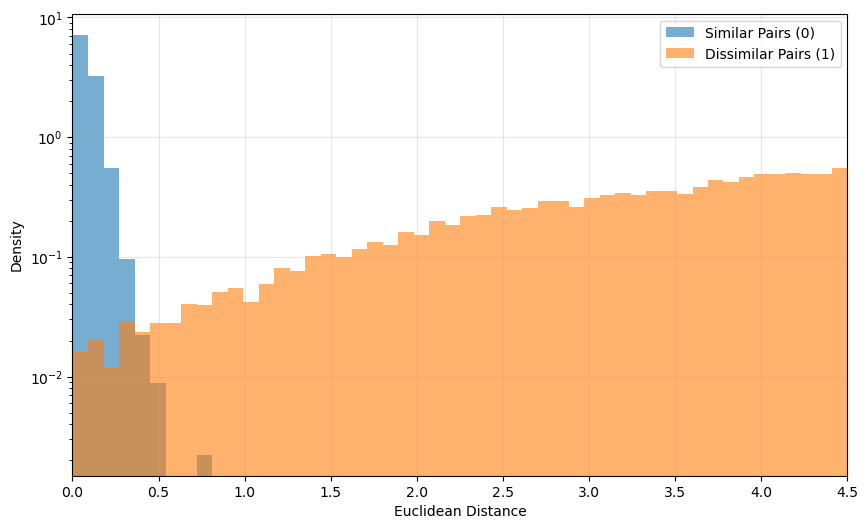

Saved t3_loss_pT0.6_keep0.3.png


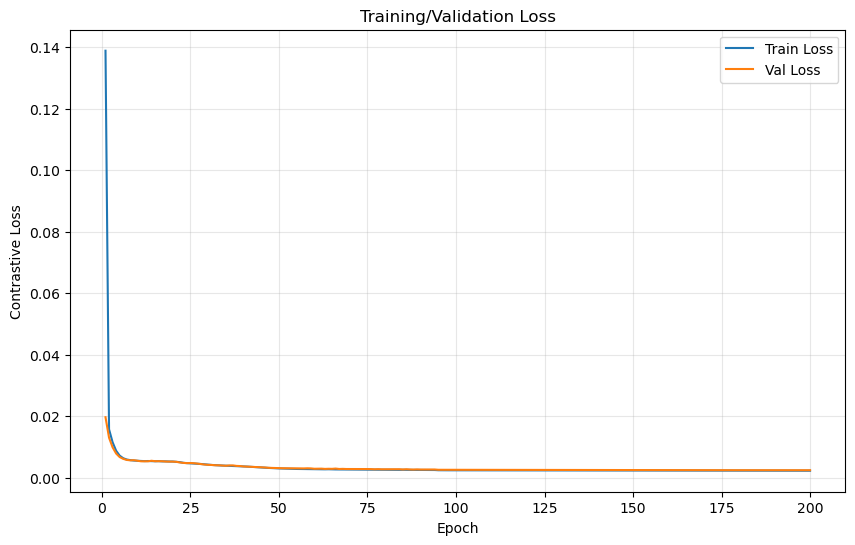

Saved t3_roc_pT0.6_keep0.3.png


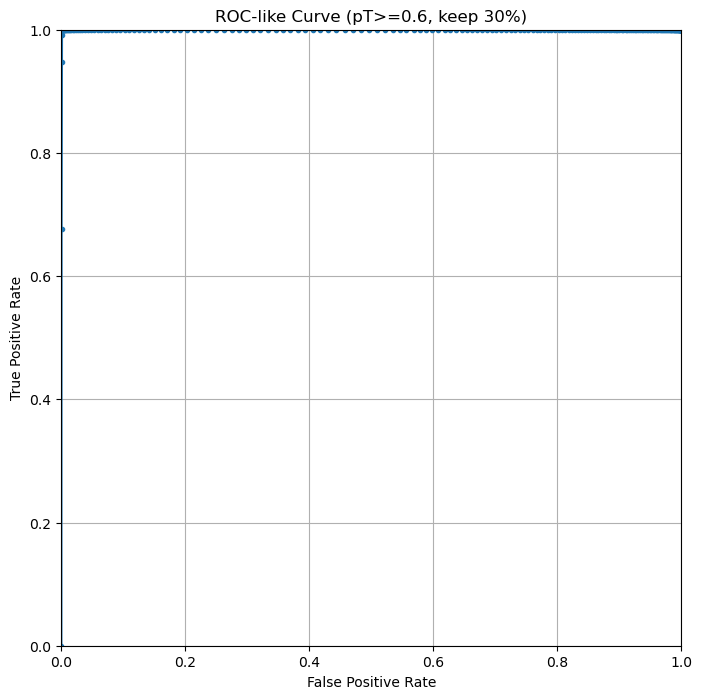


Skipping 2D embedding plot (dim != 2).


In [21]:
# ------------------------------------------------------------
# 7. Performance Evaluation and Plotting (Unchanged logic)
# ------------------------------------------------------------
print("\n--- Evaluating Model ---")
model.eval(); all_distances, all_labels = [], []
eval_start_time = time.time()
with torch.no_grad(): # (Evaluation loop unchanged)
    for batch_left, batch_right, batch_label in test_loader:
        batch_left, batch_right = batch_left.to(device), batch_right.to(device)
        distances = model(batch_left, batch_right)
        all_distances.append(distances.cpu().numpy()); all_labels.append(batch_label.numpy())
eval_end_time = time.time(); print(f"Evaluation data collection took: {eval_end_time - eval_start_time:.2f}s.")

if not all_distances: print("Error: No distances collected.")
else: # (Plotting logic unchanged, filenames updated)
    all_distances, all_labels = np.concatenate(all_distances).flatten(), np.concatenate(all_labels).flatten()
    print(f"Evaluation complete. Collected {len(all_distances)} distances.")
    if len(all_distances) == 0: print("No test data to plot.")
    else:
        print(f"Test distances range: Min={all_distances.min():.4f}, Max={all_distances.max():.4f}")
        # *** UPDATED PLOT FILENAMES ***
        dist_plot_fname = f"t3_dist_pT{pMATCHED_THRESHOLD}_keep{KEEP_FRACTION}.png"
        loss_plot_fname = f"t3_loss_pT{pMATCHED_THRESHOLD}_keep{KEEP_FRACTION}.png"
        roc_plot_fname = f"t3_roc_pT{pMATCHED_THRESHOLD}_keep{KEEP_FRACTION}.png"
        embed_plot_fname = f"t3_embed_pT{pMATCHED_THRESHOLD}_keep{KEEP_FRACTION}.png"

        # Plot 1: Distances
        plt.figure(figsize=(10, 6))
        bins = np.linspace(all_distances.min(), 4.5, 51)
        plt.hist(all_distances[all_labels == 0], bins=bins, alpha=0.6, density=True, label='Similar Pairs (0)', range=(0,4.5))
        plt.hist(all_distances[all_labels == 1], bins=bins, alpha=0.6, density=True, label='Dissimilar Pairs (1)', range=(0,4.5))
        plt.xlabel("Euclidean Distance")
        plt.ylabel("Density")
        #plt.xticks(np.arange(0, 5, 0.5))  # Set x ticks at 0, 0.5, 1, ..., 4.5
        plt.legend()
        plt.yscale('log')
        #plt.xscale('log')
        plt.grid(True, alpha=0.3)
        plt.savefig(dist_plot_fname)
        plt.xlim([0,4.5])
        print(f"Saved {dist_plot_fname}")
        plt.show()

        # Plot 2: Loss
        plt.figure(figsize=(10, 6))
        if train_losses: plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
        if val_losses: plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
        plt.xlabel("Epoch"); plt.ylabel("Contrastive Loss"); plt.title("Training/Validation Loss")
        if train_losses or val_losses: plt.legend(); plt.grid(True, alpha=0.3)
        plt.savefig(loss_plot_fname); print(f"Saved {loss_plot_fname}"); plt.show()

        # Plot 3: ROC
        n_sim, n_dis = np.sum(all_labels == 0), np.sum(all_labels == 1)
        if n_sim > 0 and n_dis > 0:
            thresholds = np.linspace(all_distances.min(), all_distances.max(), 200)
            tpr, fpr = [], []
            for t in thresholds:
                pred_sim = all_distances < t
                tpr.append(np.sum(pred_sim & (all_labels == 0)) / n_sim)
                fpr.append(np.sum(pred_sim & (all_labels == 1)) / n_dis)
            plt.figure(figsize=(8, 8)); plt.plot(fpr, tpr, marker='.')
            plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.grid(True); plt.xlim(0, 1); plt.ylim(0, 1)
            plt.title(f"ROC-like Curve (pT>={pMATCHED_THRESHOLD}, keep {KEEP_FRACTION*100:.0f}%)")
            plt.savefig(roc_plot_fname); print(f"Saved {roc_plot_fname}"); plt.show()
        else: print("Skipping ROC plot (insufficient pairs).")

        # Plot 4: Embedding (logic unchanged)
        if embedding_dim == 2:
            print("\nVisualizing embedding space...")
            evt_idx_plot = next((i for i, f in enumerate(features_per_event) if len(f) > 5), -1)
            if evt_idx_plot != -1:
                 print(f"Plotting event {evt_idx_plot} (index in final list)")
                 evt_feat_np = features_per_event[evt_idx_plot]; evt_sim = sim_indices_per_event[evt_idx_plot]
                 if len(evt_feat_np) > 0:
                     evt_feat = torch.from_numpy(evt_feat_np.astype(np.float32)).to(device)
                     with torch.no_grad(): evt_embed = model.embedding_net(evt_feat).cpu().numpy()
                     # (Coloring and plotting logic unchanged from previous version)
                     valid_sims = evt_sim[evt_sim != -1]; unique_sims = np.unique(valid_sims) if len(valid_sims) > 0 else np.array([])
                     color_count = len(unique_sims) + 1
                     try: cmap = plt.cm.viridis(np.linspace(0, 1, color_count))
                     except ValueError: cmap = plt.cm.viridis([0.5])
                     sim_to_color = {s: cmap[i] for i, s in enumerate(unique_sims)}
                     sim_to_color[-1] = cmap[-1] if color_count > 0 else cmap[0]
                     colors = [sim_to_color.get(s, sim_to_color[-1]) for s in evt_sim]
                     plt.figure(figsize=(10, 8)); plt.scatter(evt_embed[:, 0], evt_embed[:, 1], c=colors, s=50, alpha=0.8)
                     plt.xlabel("Embed Dim 1"); plt.ylabel("Embed Dim 2"); plt.grid(True, alpha=0.3)
                     plt.title(f"Embeddings (pT>={pMATCHED_THRESHOLD}, keep {KEEP_FRACTION*100:.0f}%) Event Example")
                     # (Legend logic unchanged)
                     handles = []; limit=15; indices_show=list(unique_sims[:limit]) + ([-1] if -1 in sim_to_color else [])
                     for s in indices_show:
                         lbl=f'Sim {s}' if s!=-1 else 'Unmatched (-1)'; c=sim_to_color.get(s)
                         if c is not None: handles.append(plt.Line2D([0],[0], marker='o', color='w', label=lbl, markersize=8, markerfacecolor=c))
                     if len(unique_sims)>limit: handles.append(plt.Line2D([0],[0], marker='', color='w', label='...'))
                     if handles: plt.legend(handles=handles, title="Sim Idx", bbox_to_anchor=(1.05, 1), loc='upper left'); plt.tight_layout(rect=[0,0,0.85,1])
                     else: plt.tight_layout()
                     plt.savefig(embed_plot_fname); print(f"Saved {embed_plot_fname}"); plt.show()
                 else: print("Event sample empty.")
            else: print("No suitable event found for embedding plot.")
        elif embedding_dim > 2: print("\nSkipping 2D embedding plot (dim != 2).")


In [8]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"HOST_DEVICE_CONSTANT float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"HOST_DEVICE_CONSTANT const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model.embedding_net)


HOST_DEVICE_CONSTANT float bias_fc1[32] = {
0.0028091f, 0.1505213f, 0.0252417f, 0.0262904f, -0.1692538f, 0.0981367f, 0.0167780f, 0.0067659f, -0.0827984f, -0.2289426f, 0.1330500f, 0.0929082f, -0.0908474f, 0.0145047f, -0.0957639f, -0.0583534f, -0.2469842f, 0.0242294f, -0.1934866f, 0.1293170f, 0.0874481f, -0.2626763f, 0.1723243f, -0.1628695f, -0.0108079f, 0.2082279f, 0.0382167f, -0.1020441f, -0.0866014f, -0.0955548f, 0.1401387f, 0.0263438f };

HOST_DEVICE_CONSTANT const float wgtT_fc1[16][32] = {
{ -0.8543863f, -0.6425889f, -0.8260100f, -0.4157428f, -0.1222019f, 0.6577790f, -0.6734275f, 0.3722030f, 0.8364322f, 0.0816652f, 0.7255362f, -0.3933964f, -0.8481200f, 0.5634401f, -0.0650098f, 0.1197719f, -0.1649167f, -0.4486338f, -0.0263294f, 0.7637396f, 0.4502917f, 0.3176738f, 0.6132770f, -0.0670073f, 0.0666976f, -0.5517905f, -0.4822672f, -0.5412658f, 0.5523399f, -0.2092899f, 0.0880845f, 0.6032891f },
{ 0.3546231f, -0.3261374f, -0.2657959f, -0.3098474f, -0.1355551f, 0.2089720f, 0.1810012f, -0.444

In [9]:
# %%
# ==============================================================================
# <<<<<<<<<<<<<<<<< Previous Script Code Above >>>>>>>>>>>>>>>>>>>>>>>
# Ensure that the following variables are available from the previous script:
# - model: The trained SiameseNet model (loaded with best weights)
# - device: The torch device ('cuda' or 'cpu')
# - features_per_event: The list of numpy arrays containing features for triplets
#                       *after* filtering and random discard.
# - sim_indices_per_event: The corresponding list of numpy arrays for sim indices.
# - input_dim: The input dimension of the embedding network (e.g., 14)
# ==============================================================================
import numpy as np
import torch
import random # Needed for potential random sampling within event if needed

print("\n--- Printing Multiple Example Triplet Features and Distances ---")

# --- Configuration ---
num_examples_to_find = 100   # Target number of examples for each type
search_event_limit = 200   # Search more events if needed
invalid_sim_idx = -1     # Value used for unmatched triplets

# --- Define Feature Names (Must match the order used in feature engineering) ---
feature_names = [
    "Norm Eta Hit 0", "Cos Phi Hit 0",   # <-- Updated
    "Sin Phi Hit 0", "Norm Z Hit 0", "Norm R Hit 0",
    "Norm Delta Eta (2-0)", "Norm Delta Phi (2-0)", "Norm Delta Z (2-0)", "Norm Delta R (2-0)",
    "Norm Delta Eta (4-2)", "Norm Delta Phi (4-2)", "Norm Delta Z (4-2)", "Norm Delta R (4-2)",
    "Log10 Radius", "Beta In", "RZ Chi-Squared"
]
try:
    if len(feature_names) != input_dim:
        print(f"Warning: Feature names ({len(feature_names)}) != input dim ({input_dim}).")
except NameError:
    print("Warning: 'input_dim' not found, cannot verify feature name count.")
    input_dim = 16 # Assume default


# --- Function to find MULTIPLE example pairs in an event ---
def find_multiple_pairs_in_event(event_idx, event_features, event_sim_indices, invalid_sim_idx_local, max_per_type=5):
    """Searches a single event for multiple similar and dissimilar pairs."""
    n_triplets = len(event_features)
    if n_triplets < 2: return [], []

    similar_pairs_found = []
    dissimilar_pairs_found = []
    potential_pairs = list(range(n_triplets * (n_triplets - 1) // 2))
    random.shuffle(potential_pairs) # Shuffle indices to get random pairs quickly

    checked_pairs_count = 0
    max_checks = min(n_triplets * (n_triplets - 1) // 2, 5000) # Limit checks in very dense events

    # Instead of iterating i, j, iterate through shuffled pair indices
    for pair_idx_flat in potential_pairs:
        if checked_pairs_count >= max_checks: break
        if len(similar_pairs_found) >= max_per_type and len(dissimilar_pairs_found) >= max_per_type: break

        # Convert flat pair index back to (i, j) with i < j
        # Formula: solve N*(N-1)/2 - (N-i)*(N-i-1)/2 = pair_idx_flat + 1 approx
        # Simpler: iterate i, then j (but use shuffled indices to avoid bias)
        # Let's stick to simple i,j loop but break early

        # Use a simpler i, j loop and break when counts are met
        break_outer = False
        for i in range(n_triplets):
            if break_outer: break
            sim_i = event_sim_indices[i]
            is_i_valid = sim_i != invalid_sim_idx_local

            for j in range(i + 1, n_triplets):
                sim_j = event_sim_indices[j]
                is_j_valid = sim_j != invalid_sim_idx_local

                is_similar = (sim_i == sim_j) and is_i_valid

                if is_similar and len(similar_pairs_found) < max_per_type:
                    similar_pairs_found.append((i, j))
                elif not is_similar and len(dissimilar_pairs_found) < max_per_type:
                    dissimilar_pairs_found.append((i, j))

                # Check if we have enough of both types
                if len(similar_pairs_found) >= max_per_type and len(dissimilar_pairs_found) >= max_per_type:
                    break_outer = True
                    break # Break inner loop

    return similar_pairs_found, dissimilar_pairs_found


# --- Function to calculate distance (Unchanged) ---
def get_embedding_distance(model, device, features_left, features_right):
    model.eval()
    with torch.no_grad():
        t_left = torch.from_numpy(features_left.astype(np.float32)).unsqueeze(0).to(device)
        t_right = torch.from_numpy(features_right.astype(np.float32)).unsqueeze(0).to(device)
        distance_tensor = model(t_left, t_right)
        distance = distance_tensor.item()
    return distance

# --- Function to print details (Unchanged) ---
def print_pair_details(title, event_idx, idx_L, idx_R, sim_L, sim_R, feat_L, feat_R, distance, feature_names):
    print(f"\n--- {title} ---")
    print(f"Event Index: {event_idx}")
    print(f"Triplet Indices: ({idx_L}, {idx_R})")
    print(f"Sim Indices: ({sim_L}, {sim_R})")
    print("-" * (len(title) + 6))
    header = f"{'Feature Name':<25} | {'Triplet Left':<15} | {'Triplet Right':<15}"
    print(header)
    print("-" * len(header))
    for k, name in enumerate(feature_names):
        val_L_str = f"{feat_L[k]:<15.4f}" if k < len(feat_L) else "N/A"
        val_R_str = f"{feat_R[k]:<15.4f}" if k < len(feat_R) else "N/A"
        print(f"{name:<25} | {val_L_str} | {val_R_str}")
    print("-" * len(header))
    print(f"Calculated Embedding Distance: {distance:.6f}")
    print("-" * (len(title) + 6))


# --- Main logic to find and print multiple examples ---
similar_examples_list = []
dissimilar_examples_list = []

# Check if features_per_event exists and is not empty
if 'features_per_event' not in locals() or not features_per_event:
     print("Error: 'features_per_event' not available or empty. Cannot proceed.")
else:
    actual_search_limit = min(search_event_limit, len(features_per_event))
    print(f"Searching first {actual_search_limit} events for {num_examples_to_find} examples of each pair type...")

    events_searched = 0
    for current_event_idx in range(actual_search_limit):
        events_searched += 1
        # Check if we have found enough examples already
        if len(similar_examples_list) >= num_examples_to_find and len(dissimilar_examples_list) >= num_examples_to_find:
            print(f"\nFound desired number of examples ({num_examples_to_find}) after searching {events_searched} events. Stopping search.")
            break

        if current_event_idx >= len(features_per_event): continue # Should not happen with loop limit

        event_features = features_per_event[current_event_idx]
        event_sim_indices = sim_indices_per_event[current_event_idx]

        if len(event_features) < 2: continue # Skip events with fewer than 2 triplets

        # Find potentially multiple pairs in this event
        # Ask for slightly more than needed in case some are duplicates across events (unlikely but possible)
        needed_sim = max(1, num_examples_to_find - len(similar_examples_list))
        needed_dissim = max(1, num_examples_to_find - len(dissimilar_examples_list))
        max_from_event = max(needed_sim, needed_dissim, 3) # Get at least a few per event if possible

        sim_pairs_found_in_event, dissim_pairs_found_in_event = find_multiple_pairs_in_event(
            current_event_idx, event_features, event_sim_indices, invalid_sim_idx, max_per_type=max_from_event
        )

        # Add found similar pairs to the list if needed
        for idx_L, idx_R in sim_pairs_found_in_event:
            if len(similar_examples_list) >= num_examples_to_find: break
            if idx_L < len(event_features) and idx_R < len(event_features):
                 similar_examples_list.append({
                     "event_idx": current_event_idx,
                     "idx_L": idx_L, "idx_R": idx_R,
                     "sim_L": event_sim_indices[idx_L], "sim_R": event_sim_indices[idx_R],
                     "feat_L": event_features[idx_L], "feat_R": event_features[idx_R]
                 })

        # Add found dissimilar pairs to the list if needed
        for idx_L, idx_R in dissim_pairs_found_in_event:
            if len(dissimilar_examples_list) >= num_examples_to_find: break
            if idx_L < len(event_features) and idx_R < len(event_features):
                 dissimilar_examples_list.append({
                     "event_idx": current_event_idx,
                     "idx_L": idx_L, "idx_R": idx_R,
                     "sim_L": event_sim_indices[idx_L], "sim_R": event_sim_indices[idx_R],
                     "feat_L": event_features[idx_L], "feat_R": event_features[idx_R]
                 })

    print(f"\nSearch complete after {events_searched} events.")
    print(f"Found {len(similar_examples_list)} similar pair examples.")
    print(f"Found {len(dissimilar_examples_list)} dissimilar pair examples.")

    # --- Print the collected examples ---
    print("\n" + "="*20 + " SIMILAR PAIR EXAMPLES " + "="*20)
    if similar_examples_list:
        for i, example in enumerate(similar_examples_list):
            dist_sim = get_embedding_distance(model, device, example["feat_L"], example["feat_R"])
            print_pair_details(f"Similar Pair Example #{i+1}",
                               example["event_idx"],
                               example["idx_L"], example["idx_R"],
                               example["sim_L"], example["sim_R"],
                               example["feat_L"], example["feat_R"],
                               dist_sim, feature_names)
            if i < len(similar_examples_list) - 1: print("\n" + "-"*70 + "\n") # Separator
    else:
        print("No similar pair examples were found.")

    print("\n" + "="*20 + " DISSIMILAR PAIR EXAMPLES " + "="*20)
    if dissimilar_examples_list:
        for i, example in enumerate(dissimilar_examples_list):
            dist_dissim = get_embedding_distance(model, device, example["feat_L"], example["feat_R"])
            print_pair_details(f"Dissimilar Pair Example #{i+1}",
                               example["event_idx"],
                               example["idx_L"], example["idx_R"],
                               example["sim_L"], example["sim_R"],
                               example["feat_L"], example["feat_R"],
                               dist_dissim, feature_names)
            if i < len(dissimilar_examples_list) - 1: print("\n" + "-"*70 + "\n") # Separator
    else:
        print("No dissimilar pair examples were found.")

print("\n--- End of Example Printout ---")

# %%
# ==============================================================================
# End of example printing code
# ==============================================================================


--- Printing Multiple Example Triplet Features and Distances ---
Searching first 200 events for 100 examples of each pair type...

Found desired number of examples (100) after searching 2 events. Stopping search.

Search complete after 2 events.
Found 100 similar pair examples.
Found 100 dissimilar pair examples.

==================== SIMILAR PAIR EXAMPLES ====================

--- Similar Pair Example #1 ---
Event Index: 0
Triplet Indices: (0, 90)
Sim Indices: (147299, 147299)
-----------------------------
Feature Name              | Triplet Left    | Triplet Right  
-------------------------------------------------------------
Norm Eta Hit 0            | -0.7642         | -0.7639        
Cos Phi Hit 0             | 0.9665          | 0.9639         
Sin Phi Hit 0             | 0.2567          | 0.2662         
Norm Z Hit 0              | -0.4829         | -0.5880        
Norm R Hit 0              | 0.2392          | 0.2915         
Norm Delta Eta (2-0)      | 0.0002          | 0.0002

In [10]:
# %%
# ==============================================================================
# <<<<<<<<<<<<<<<<< Previous Script Code Above >>>>>>>>>>>>>>>>>>>>>>>
# Ensure that the following variables are available from the previous script:
# - model: The trained SiameseNet model (loaded with best weights)
# - device: The torch device ('cuda' or 'cpu')
# - features_per_event: The list of numpy arrays containing features for triplets
#                       *after* filtering and random discard.
# - sim_indices_per_event: The corresponding list of numpy arrays for sim indices.
# - input_dim: The input dimension of the embedding network (e.g., 14)
# ==============================================================================
import numpy as np
import torch
import random

print("\n--- Finding High-Distance Similar Pair Examples ---")

# --- Configuration ---
DISTANCE_THRESHOLD = 0.5     # Find similar pairs with distance ABOVE this
num_examples_to_find = 5      # Target number of examples
search_event_limit = 300     # Search more events if needed
invalid_sim_idx = -1        # Value used for unmatched triplets

# --- Define Feature Names (Must match the order used in feature engineering) ---
feature_names = [
    "Norm Eta Hit 0", "Cos Phi Hit 0",   # <-- Updated
    "Sin Phi Hit 0", "Norm Z Hit 0", "Norm R Hit 0",
    "Norm Delta Eta (2-0)", "Norm Delta Phi (2-0)", "Norm Delta Z (2-0)", "Norm Delta R (2-0)",
    "Norm Delta Eta (4-2)", "Norm Delta Phi (4-2)", "Norm Delta Z (4-2)", "Norm Delta R (4-2)",
    "Log10 Radius", "Beta In", "RZ Chi-Squared"
]
try:
    if len(feature_names) != input_dim:
        print(f"Warning: Feature names ({len(feature_names)}) != input dim ({input_dim}).")
except NameError:
    print("Warning: 'input_dim' not found, cannot verify feature name count.")
    input_dim = 14 # Assume default


# --- Function to calculate distance (Unchanged) ---
def get_embedding_distance(model, device, features_left, features_right):
    model.eval()
    with torch.no_grad():
        t_left = torch.from_numpy(features_left.astype(np.float32)).unsqueeze(0).to(device)
        t_right = torch.from_numpy(features_right.astype(np.float32)).unsqueeze(0).to(device)
        distance_tensor = model(t_left, t_right)
        distance = distance_tensor.item()
    return distance

# --- Function to print details (Unchanged) ---
def print_pair_details(title, event_idx, idx_L, idx_R, sim_L, sim_R, feat_L, feat_R, distance, feature_names):
    print(f"\n--- {title} ---")
    print(f"Event Index: {event_idx}")
    print(f"Triplet Indices: ({idx_L}, {idx_R})")
    print(f"Sim Indices: ({sim_L}, {sim_R})")
    print("-" * (len(title) + 6))
    header = f"{'Feature Name':<25} | {'Triplet Left':<15} | {'Triplet Right':<15}"
    print(header)
    print("-" * len(header))
    for k, name in enumerate(feature_names):
        val_L_str = f"{feat_L[k]:<15.4f}" if k < len(feat_L) else "N/A"
        val_R_str = f"{feat_R[k]:<15.4f}" if k < len(feat_R) else "N/A"
        print(f"{name:<25} | {val_L_str} | {val_R_str}")
    print("-" * len(header))
    print(f"Calculated Embedding Distance: {distance:.6f} (> {DISTANCE_THRESHOLD})") # Highlight condition
    print("-" * (len(title) + 6))


# --- Function to find high-distance similar pairs in an event ---
def find_high_dist_similar_pairs_in_event(event_idx, event_features, event_sim_indices, invalid_sim_idx_local,
                                          model, device, distance_threshold, max_to_find=1):
    """Searches a single event for similar pairs with distance > threshold."""
    n_triplets = len(event_features)
    if n_triplets < 2: return []

    found_pairs_list = []

    # Optimization: Group triplets by valid sim index first
    sim_dict = {}
    valid_sim_mask = (event_sim_indices != invalid_sim_idx_local)
    for idx in range(n_triplets):
        if valid_sim_mask[idx]:
            sim = event_sim_indices[idx]
            sim_dict.setdefault(sim, []).append(idx)

    # Iterate through groups that have potential pairs
    for sim, indices in sim_dict.items():
        if len(indices) < 2: continue # Need at least two triplets with the same sim index

        # Check pairs within this group
        for i_local in range(len(indices)):
            if len(found_pairs_list) >= max_to_find: break # Stop if we found enough

            idx_L = indices[i_local]
            feat_L = event_features[idx_L]

            for j_local in range(i_local + 1, len(indices)):
                if len(found_pairs_list) >= max_to_find: break # Stop if we found enough

                idx_R = indices[j_local]
                feat_R = event_features[idx_R]

                # Calculate distance for this similar pair
                distance = get_embedding_distance(model, device, feat_L, feat_R)

                # Check if distance meets the threshold
                if distance > distance_threshold:
                    found_pairs_list.append({
                        "event_idx": event_idx,
                        "idx_L": idx_L, "idx_R": idx_R,
                        "sim_L": sim, "sim_R": sim, # They must be the same valid sim index
                        "feat_L": feat_L, "feat_R": feat_R,
                        "distance": distance
                    })
                    # Optional: Print intermediate finds for debugging
                    # print(f"  Found high-dist similar pair in event {event_idx}: dist={distance:.4f}")

            if len(found_pairs_list) >= max_to_find: break # Stop if we found enough in this group

        if len(found_pairs_list) >= max_to_find: break # Stop if we found enough overall

    return found_pairs_list


# --- Main logic to find and print multiple high-distance similar examples ---
high_dist_similar_examples = []

if 'features_per_event' not in locals() or not features_per_event:
     print("Error: 'features_per_event' not available or empty. Cannot proceed.")
else:
    actual_search_limit = min(search_event_limit, len(features_per_event))
    print(f"Searching first {actual_search_limit} events for {num_examples_to_find} similar pairs with distance > {DISTANCE_THRESHOLD}...")

    events_searched = 0
    for current_event_idx in range(actual_search_limit):
        events_searched += 1
        # Check if we have found enough examples already
        if len(high_dist_similar_examples) >= num_examples_to_find:
            print(f"\nFound desired number of examples ({num_examples_to_find}) after searching {events_searched} events. Stopping search.")
            break

        if current_event_idx >= len(features_per_event): continue

        event_features = features_per_event[current_event_idx]
        event_sim_indices = sim_indices_per_event[current_event_idx]

        if len(event_features) < 2: continue

        # Find high-distance similar pairs in this event
        needed = max(1, num_examples_to_find - len(high_dist_similar_examples))

        pairs_from_event = find_high_dist_similar_pairs_in_event(
            current_event_idx, event_features, event_sim_indices, invalid_sim_idx,
            model, device, DISTANCE_THRESHOLD, max_to_find=needed
        )

        # Add found pairs to the main list
        if pairs_from_event:
             print(f"  Found {len(pairs_from_event)} high-dist similar pairs in event {current_event_idx}.")
             high_dist_similar_examples.extend(pairs_from_event)
             # Ensure we don't overshoot significantly (though max_to_find should handle this)
             high_dist_similar_examples = high_dist_similar_examples[:num_examples_to_find]


    print(f"\nSearch complete after {events_searched} events.")
    print(f"Found {len(high_dist_similar_examples)} similar pair examples with distance > {DISTANCE_THRESHOLD}.")

    # --- Print the collected examples ---
    print("\n" + "="*20 + f" SIMILAR PAIRS (Dist > {DISTANCE_THRESHOLD}) " + "="*20)
    if high_dist_similar_examples:
        for i, example in enumerate(high_dist_similar_examples):
            # Distance is already calculated and stored in the example dict
            print_pair_details(f"High-Dist Similar Pair #{i+1}",
                               example["event_idx"],
                               example["idx_L"], example["idx_R"],
                               example["sim_L"], example["sim_R"],
                               example["feat_L"], example["feat_R"],
                               example["distance"], # Use stored distance
                               feature_names)
            if i < len(high_dist_similar_examples) - 1: print("\n" + "-"*70 + "\n") # Separator
    else:
        print(f"No similar pair examples with distance > {DISTANCE_THRESHOLD} were found in the first {events_searched} events.")

print("\n--- End of High-Distance Similar Pair Example Printout ---")

# %%
# ==============================================================================
# End of example printing code
# ==============================================================================


--- Finding High-Distance Similar Pair Examples ---
Searching first 300 events for 5 similar pairs with distance > 0.5...
  Found 3 high-dist similar pairs in event 0.
  Found 1 high-dist similar pairs in event 1.
  Found 1 high-dist similar pairs in event 2.

Found desired number of examples (5) after searching 4 events. Stopping search.

Search complete after 4 events.
Found 5 similar pair examples with distance > 0.5.

==================== SIMILAR PAIRS (Dist > 0.5) ====================

--- High-Dist Similar Pair #1 ---
Event Index: 0
Triplet Indices: (653, 2094)
Sim Indices: (155156, 155156)
-------------------------------
Feature Name              | Triplet Left    | Triplet Right  
-------------------------------------------------------------
Norm Eta Hit 0            | -0.3722         | -0.3431        
Cos Phi Hit 0             | 0.2384          | 0.4524         
Sin Phi Hit 0             | 0.9712          | 0.8918         
Norm Z Hit 0              | -0.1215         | -0.3201

In [22]:
# %%
# ==============================================================================
# <<<<<<<<<<<<<<<<< Finding Low-Distance Dissimilar Pair Examples >>>>>>>>>>>>>>>>
# Ensure that the following variables from the previous script are available:
# - model: The trained SiameseNet model (loaded with best weights)
# - device: The torch device ('cuda' or 'cpu')
# - features_per_event: The list of numpy arrays containing features for triplets
#                       *after* filtering and random discard.
# - sim_indices_per_event: The corresponding list of numpy arrays for sim indices.
# - input_dim: The input dimension of the embedding network (e.g., 14)
# ==============================================================================
import numpy as np
import torch
import random

print("\n--- Finding Low-Distance Dissimilar Pair Examples ---")

# --- Configuration for dis-similar pairs ---
DISIMILAR_DISTANCE_THRESHOLD = 0.3  # Find dis-similar pairs with distance BELOW this
num_dissimilar_examples_to_find = 5  # Target number of dis-similar examples
search_event_limit = 300             # Search more events if needed
invalid_sim_idx = -1                 # Value used for unmatched triplets

# --- Use same feature names as before ---
feature_names = [
    "Norm Eta Hit 0", "Cos Phi Hit 0",   # <-- Updated
    "Sin Phi Hit 0", "Norm Z Hit 0", "Norm R Hit 0",
    "Norm Delta Eta (2-0)", "Norm Delta Phi (2-0)", "Norm Delta Z (2-0)", "Norm Delta R (2-0)",
    "Norm Delta Eta (4-2)", "Norm Delta Phi (4-2)", "Norm Delta Z (4-2)", "Norm Delta R (4-2)",
    "Log10 Radius", "Beta In", "RZ Chi-Squared"
]
try:
    if len(feature_names) != input_dim:
        print(f"Warning: Feature names ({len(feature_names)}) != input dim ({input_dim}).")
except NameError:
    print("Warning: 'input_dim' not found, cannot verify feature name count.")
    input_dim = 14  # Assume default

# --- Reuse the function to calculate distance ---
def get_embedding_distance(model, device, features_left, features_right):
    model.eval()
    with torch.no_grad():
        t_left = torch.from_numpy(features_left.astype(np.float32)).unsqueeze(0).to(device)
        t_right = torch.from_numpy(features_right.astype(np.float32)).unsqueeze(0).to(device)
        distance_tensor = model(t_left, t_right)
        distance = distance_tensor.item()
    return distance

# --- New function to print dis-similar pair details ---
def print_dissimilar_pair_details(title, event_idx, idx_L, idx_R, sim_L, sim_R, feat_L, feat_R, distance, feature_names, threshold):
    print(f"\n--- {title} ---")
    print(f"Event Index: {event_idx}")
    print(f"Triplet Indices: ({idx_L}, {idx_R})")
    print(f"Sim Indices: ({sim_L}, {sim_R})")
    print("-" * (len(title) + 6))
    header = f"{'Feature Name':<25} | {'Triplet Left':<15} | {'Triplet Right':<15}"
    print(header)
    print("-" * len(header))
    for k, name in enumerate(feature_names):
        val_L_str = f"{feat_L[k]:<15.4f}" if k < len(feat_L) else "N/A"
        val_R_str = f"{feat_R[k]:<15.4f}" if k < len(feat_R) else "N/A"
        print(f"{name:<25} | {val_L_str} | {val_R_str}")
    print("-" * len(header))
    print(f"Calculated Embedding Distance: {distance:.6f} (< {threshold})")  # Highlight condition for dis-similarity
    print("-" * (len(title) + 6))

# --- Function to find low-distance dis-similar pairs in an event ---
def find_low_dist_dissimilar_pairs_in_event(event_idx, event_features, event_sim_indices, invalid_sim_idx_local,
                                            model, device, distance_threshold, max_to_find=1):
    """
    Searches a single event for dis-similar pairs (triplets with different valid sim indices)
    that have an embedding distance lower than the specified threshold.
    """
    n_triplets = len(event_features)
    if n_triplets < 2:
        return []

    found_pairs_list = []

    # Iterate through all unique pairs in the event
    for i in range(n_triplets):
        for j in range(i + 1, n_triplets):
            # Skip if either triplet does not have a valid sim index
            if event_sim_indices[i] == invalid_sim_idx_local or event_sim_indices[j] == invalid_sim_idx_local:
                continue

            # Only consider pairs with different sim indices
            if event_sim_indices[i] == event_sim_indices[j]:
                continue

            # Calculate embedding distance for this dis-similar pair
            distance = get_embedding_distance(model, device, event_features[i], event_features[j])

            # Check if distance meets the dis-similar condition (< threshold)
            if distance < distance_threshold:
                found_pairs_list.append({
                    "event_idx": event_idx,
                    "idx_L": i, "idx_R": j,
                    "sim_L": event_sim_indices[i], "sim_R": event_sim_indices[j],
                    "feat_L": event_features[i], "feat_R": event_features[j],
                    "distance": distance
                })
                # Stop early if we have enough pairs from this event
                if len(found_pairs_list) >= max_to_find:
                    break
        if len(found_pairs_list) >= max_to_find:
            break

    return found_pairs_list

# --- Main logic to find and print multiple dis-similar examples ---
dissimilar_examples = []

if 'features_per_event' not in locals() or not features_per_event:
    print("Error: 'features_per_event' not available or empty. Cannot proceed.")
else:
    actual_search_limit = min(search_event_limit, len(features_per_event))
    print(f"Searching first {actual_search_limit} events for {num_dissimilar_examples_to_find} dis-similar pairs with distance < {DISIMILAR_DISTANCE_THRESHOLD}...")

    events_searched = 0
    for current_event_idx in range(actual_search_limit):
        events_searched += 1
        # Stop if we have found enough examples already
        if len(dissimilar_examples) >= num_dissimilar_examples_to_find:
            print(f"\nFound desired number of examples ({num_dissimilar_examples_to_find}) after searching {events_searched} events. Stopping search.")
            break

        if current_event_idx >= len(features_per_event):
            continue

        event_features = features_per_event[current_event_idx]
        event_sim_indices = sim_indices_per_event[current_event_idx]

        if len(event_features) < 2:
            continue

        # Find dis-similar pairs in this event
        needed = max(1, num_dissimilar_examples_to_find - len(dissimilar_examples))

        pairs_from_event = find_low_dist_dissimilar_pairs_in_event(
            current_event_idx, event_features, event_sim_indices, invalid_sim_idx,
            model, device, DISIMILAR_DISTANCE_THRESHOLD, max_to_find=needed
        )

        # Add found pairs to the main list
        if pairs_from_event:
            print(f"  Found {len(pairs_from_event)} low-distance dis-similar pairs in event {current_event_idx}.")
            dissimilar_examples.extend(pairs_from_event)
            dissimilar_examples = dissimilar_examples[:num_dissimilar_examples_to_find]

    print(f"\nSearch complete after {events_searched} events.")
    print(f"Found {len(dissimilar_examples)} dis-similar pair examples with distance < {DISIMILAR_DISTANCE_THRESHOLD}.")

    # --- Print the collected dis-similar examples ---
    print("\n" + "="*20 + f" DISSIMILAR PAIRS (Dist < {DISIMILAR_DISTANCE_THRESHOLD}) " + "="*20)
    if dissimilar_examples:
        for i, example in enumerate(dissimilar_examples):
            print_dissimilar_pair_details(f"Dissimilar Pair #{i+1}",
                                          example["event_idx"],
                                          example["idx_L"], example["idx_R"],
                                          example["sim_L"], example["sim_R"],
                                          example["feat_L"], example["feat_R"],
                                          example["distance"],  # Use stored distance
                                          feature_names,
                                          DISIMILAR_DISTANCE_THRESHOLD)
            if i < len(dissimilar_examples) - 1:
                print("\n" + "-"*70 + "\n")
    else:
        print(f"No dis-similar pair examples with distance < {DISIMILAR_DISTANCE_THRESHOLD} were found in the first {events_searched} events.")

print("\n--- End of Low-Distance Dissimilar Pair Example Printout ---")


--- Finding Low-Distance Dissimilar Pair Examples ---
Searching first 300 events for 5 dis-similar pairs with distance < 0.3...
  Found 5 low-distance dis-similar pairs in event 0.

Found desired number of examples (5) after searching 2 events. Stopping search.

Search complete after 2 events.
Found 5 dis-similar pair examples with distance < 0.3.

==================== DISSIMILAR PAIRS (Dist < 0.3) ====================

--- Dissimilar Pair #1 ---
Event Index: 0
Triplet Indices: (2, 203)
Sim Indices: (74, 138032)
------------------------
Feature Name              | Triplet Left    | Triplet Right  
-------------------------------------------------------------
Norm Eta Hit 0            | -0.7537         | -0.7384        
Cos Phi Hit 0             | 0.0637          | 0.1662         
Sin Phi Hit 0             | 0.9980          | 0.9861         
Norm Z Hit 0              | -0.4829         | -0.6856        
Norm R Hit 0              | 0.2470          | 0.3675         
Norm Delta Eta (2-0)  